In [1]:
def get_pipeline(vuelo, zona):
    if vuelo.startswith('vuelo'):
        class_range = '[4:]'
    else:
        class_range = '[3:5]'
    
    return f'''
{{
  "pipeline":[
    {{
      "type":"readers.pgpointcloud",
      "connection":"host='172.17.0.2' dbname='pointclouds' user='postgres' password='ventanuco' port='5432'",
      "table":"{vuelo}_zona{zona}",
      "spatialreference":"EPSG:25830",
      "where": "pc_numpoints(pa) is not null"
    }},
    {{
      "type":"filters.hag_dem",
      "raster": "MDT/MDT02-ETRS89-HU30-0174-2-COB2.tif"
    }},
    {{
      "type": "filters.range",
      "limits": "Classification{class_range},HeightAboveGround[0.2:15]"
    }},
    {{
      "type": "filters.python",
      "function": "make_plot",
      "module": "anything",
      "script": "./histogram.py",
      "pdalargs": {{"vuelo": "{vuelo}", "zona": "{zona}"}}
    }},
    {{
      "type": "writers.null"
    }}
  ]
}}
'''

In [6]:
get_pipeline(1,1)

'\n{\n  "pipeline":[\n    {\n      "type":"readers.pgpointcloud",\n      "connection":"host=\'172.17.0.2\' dbname=\'pointclouds\' user=\'postgres\' password=\'ventanuco\' port=\'5432\'",\n      "table":"1_zona1",\n      "spatialreference":"EPSG:25830",\n      "where": "pc_numpoints(pa) is not null"\n    },\n    {\n      "type":"filters.hag_dem",\n      "raster": "MDT/MDT02-ETRS89-HU30-0174-2-COB2.tif"\n    },\n    {\n      "type": "filters.range",\n      "limits": "Classification[3:5],HeightAboveGround[0.2:]"\n    },\n    {\n      "type": "filters.python",\n      "function": "make_plot",\n      "module": "anything",\n      "script": "./histogram.py",\n      "pdalargs": {"vuelo": "1", "zona": "1"}\n    },\n    {\n      "type": "writers.null"\n    }\n  ]\n}\n'

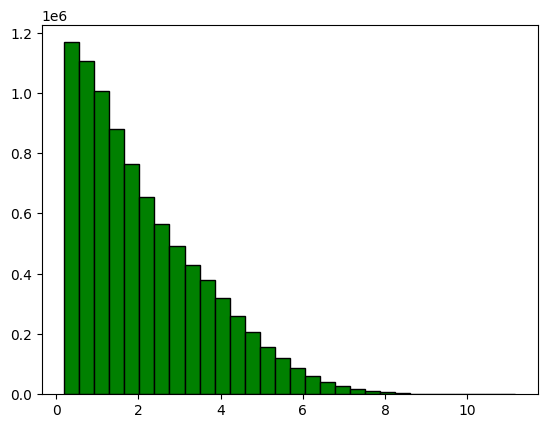

In [3]:
import pdal

for vuelo in ['lida2']:
    for zona in [3]:
        pipeline = pdal.Pipeline(get_pipeline(vuelo, zona))
        pipeline.execute()

# ALTERNATIVA PARA VUELO2_ZONA3

In [7]:
import psycopg2

conn = psycopg2.connect(database="pointclouds",
                        host="172.17.0.2",
                        user="postgres",
                        password="ventanuco",
                        port="5432")

In [16]:
def get_sql_text(id):
    return f"select pc_get(pc_explode(pa), 'heightaboveground') hag from vuelo2_zona3 where id = {id}"

In [24]:
c = conn.cursor()
c.execute('select count(pa) from vuelo2_zona3')
num_patches = c.fetchone()[0]

In [2]:
import pandas as pd

In [20]:
b = pd.DataFrame(columns=['hag'])

In [26]:
from ipywidgets import IntProgress
from IPython.display import display

f = IntProgress(min=1, max=num_patches)
display(f)

for i in range(1, num_patches):
    a = pd.read_sql(get_sql_text(i), conn)
    b = pd.concat([a, b])
    f.value = i

IntProgress(value=1, max=279, min=1)

/tmp/ipykernel_6310/1254173194.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  a = pd.read_sql(get_sql_text(i), conn)
/tmp/ipykernel_6310/1254173194.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  b = pd.concat([a, b])


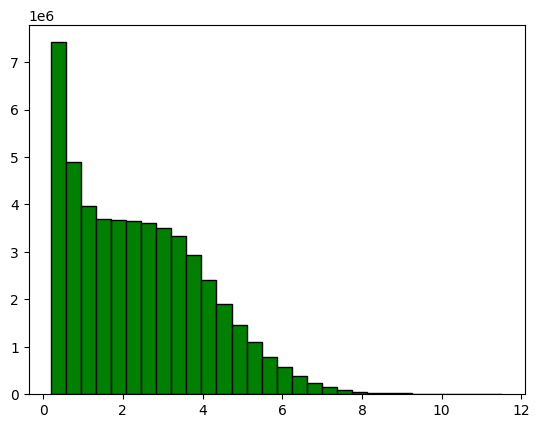

In [31]:
import matplotlib.pyplot as plt

plt.hist(b[b > 0.2], bins=30, color='green', edgecolor='black')

plt.savefig('FINALES/HISTOGRAM/histogram_vuelo2_zona3.png', bbox_inches='tight')